## Topics Covered
- Mean-Variance Portfolio Theory
- Efficient Frontier

## Dataset
- ind30_m_vw_rets.csv: returns from 30 different industries

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import utils_week1_risk_measures as utils

rets = pd.read_csv("data/ind30_m_vw_rets.csv", index_col=0, header=0)
rets.index = pd.to_datetime(rets.index, format='%Y%m')
rets.index = rets.index.to_period("M")
rets.columns = [col.strip(" ") for col in rets.columns]
rets = rets/100

### Computing the Efficient Frontier for Two Assets

In [5]:
def compute_portfolio_return(weights, ann_rets):
    port_return = weights.T @ ann_rets
    return port_return

def compute_portfolio_vol(weights, cov):
    port_vol = weights.T @ cov @ weights
    return np.sqrt(port_vol)

# function generates a plot of the efficient frontier
def plot_ef_2_asset(rets, num_points):
    
    # annualize the returns
    ann_rets = utils.annualized_return(rets, period='month')
    
    # generate a list of weights for the two assets
    weight_list = [np.array([w, 1-w]) for w in np.linspace(0, 1, num_points)]    
    cov = rets.cov()*12
    
    # compute the portfolio returns and volatilities
    port_returns = [compute_portfolio_return(weights, ann_rets) for weights in weight_list]
    port_vols = [compute_portfolio_vol(weights, cov) for weights in weight_list]
    
    # plot the efficient frontier
    plt.scatter(port_vols, port_returns)
    plt.plot(port_vols, port_returns)
    plt.xlabel("Volatility")
    plt.ylabel("Returns")
    plt.title("Portfolio Returns vs. Volatility")



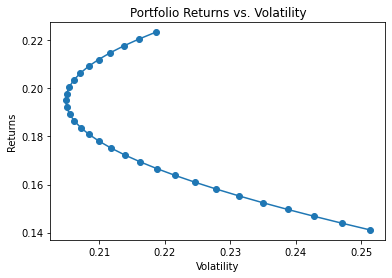

In [6]:
# extract the returns from two industries 
rets_ = rets[['Fin', 'Beer']]
rets_ = rets_["1996":"2000"]
num_points = 30
plot_ef_2_asset(rets_, num_points)

### Computing the Efficient Frontier for Many Assets

In [7]:
# function finds the porfolio weights that minimizes the volatility for a given level of return (target return)
def minimize_vol(target_return, ann_rets, cov):
    
    def constraint1(weights):
        return target_return - compute_portfolio_return(weights, ann_rets)
        
    def constraint2(weights):
        return sum(weights) - 1
    
    n = len(ann_rets)
    init_guess = [1/n]*n  # let the initial guess be the equally weighted
    bounds = ((0, 1), )*n # bounds for each weight
    
    # constraints
    return_is_target = {
                        'type': 'eq',
                        'fun': constraint1
                       }
    
    weight_sum_is_1 = {
                        'type':'eq',
                        'fun':constraint2
                      }
    
    # optimization function: we're minimizing the portfolio volatility
    result = minimize(compute_portfolio_vol,
                      init_guess,
                      args=(cov,),
                      method='SLSQP',
                      options={'disp': False},
                      constraints=(return_is_target, weight_sum_is_1),
                      bounds=bounds)
    
    weights = result.x
    return weights

# function finds the optimals weights for a target_return
def optimal_weights(n_points, ann_rets, cov):
    target_returns = np.linspace(ann_rets.min(), ann_rets.max(), n_points)
    weights = [minimize_vol(target_return, ann_rets, cov) for target_return in target_returns]
    return weights

# plot the efficient frontier from multiple assets
def plot_ef(rets, num_points, rf=None, gmv=False):
    
    # annualize the return 
    ann_rets = utils.annualized_return(rets, period='month')    
    cov = rets.cov()*12
    
    # find the optimal weights for each target return
    weight_list = optimal_weights(num_points, ann_rets, cov)
    port_returns = [compute_portfolio_return(weights, ann_rets) for weights in weight_list]
    port_vols = [compute_portfolio_vol(weights, cov) for weights in weight_list]
    
    # If the risk-free rate is provided, compute the Max Sharpe Ratio portfolio
    if rf:
        msr_port_weights = max_sharpe_ratio(ann_rets, cov, rf)
        msr_return = compute_portfolio_return(msr_port_weights, ann_rets)
        msr_vol = compute_portfolio_vol(msr_port_weights, cov)
        
        max_sharpe = (msr_return - rf)/msr_vol
        vols = np.linspace(0, max(port_vols), num_points)
        tangent_returns = [max_sharpe*vol + rf for vol in vols]
        
        plt.scatter(msr_vol, msr_return, color='red', marker='o', s=300, label='max. sharpe ratio portfolio')
        plt.plot(vols, tangent_returns, color='red')
    
    # if gmv is True, find the global minimum variance portfolio
    if gmv:
        gmv_port_weights = min_var(ann_rets, cov)
        gmv_return = compute_portfolio_return(gmv_port_weights, ann_rets)
        gmv_vol = compute_portfolio_vol(gmv_port_weights, cov)
        plt.scatter(gmv_vol, gmv_return, color='green', marker='o', s=300, label='min var. portfolio')
        
    # plot the efficient frontier
    plt.plot(port_vols, port_returns, linestyle='--', marker='o', label='efficient portfolios')
    plt.xlim(0)
    plt.xlabel("Volatility", size=15)
    plt.ylabel("Returns", size=15)
    plt.title('Portfolio Returns vs. Volatility', size=15)
    plt.legend()


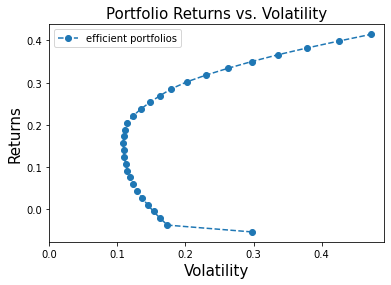

In [8]:
rets_ = rets["1996":"2000"]
num_points = 30
plot_ef(rets_, num_points)

### Finding the Max Sharpe Ratio Portfolio

- When we introduce a risk-free asset, the efficient frontier changes. We are able to construct all portfolios that lie along the straight line that starts from the risk-free asset and intersects the set of possible portfolios. 

In [9]:
# function finds the porfolio weights of the max_sharpe_ratio portfolio
def max_sharpe_ratio(ann_rets, cov, rf):
           
    def constraint1(weights):
        return sum(weights) - 1
    
    # optimization function (negation of the Sharpe Ratio)
    def negative_sharpe_ratio(weights):
        port_return = compute_portfolio_return(weights, ann_rets)
        port_vol = compute_portfolio_vol(weights, cov)
        neg_sharpe = -(port_return - rf)/port_vol
        return neg_sharpe
    
    n = len(ann_rets)
    init_guess = [1/n]*n  # let the initial guess be the equally weighted
    bounds = ((0, 1), )*n # bounds for each weight
    
    # constraints
    weight_sum_is_1 = {
                        'type': 'eq',
                        'fun': constraint1
                       }
    
    # optimization function: we're maximizing the Sharpe Ratio (minimizing the Negative Sharpe Ratio)
    result = minimize(negative_sharpe_ratio,
                      init_guess,
                      method='SLSQP',
                      options={'disp': False},
                      constraints=weight_sum_is_1,
                      bounds=bounds)
    
    weights = result.x
    return weights

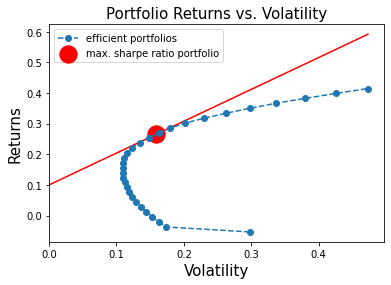

In [11]:
rets_ = rets["1996":"2000"]
num_points = 30
rf = 0.1

# supply the plot_ef function with a risk-free rate to get the tangent portfolio
plot_ef(rets_, num_points, rf)

### Finding the Minimum Variance Portfolio

In [12]:
# function finds the weight of the minimum variance portfolio
def min_var(ann_rets, cov):
    
    def constraint1(weights):
        return sum(weights) - 1
    
    def compute_portfolio_vol(weights):
        port_vol = weights.T @ cov @ weights
        return np.sqrt(port_vol)
    
    n = ann_rets.shape[0]
    init_guess = [1/n]*n
    bounds = ((0, 1), )*n
    
    # constraints
    weight_sum_is_1 = {
                        'type':'eq',
                        'fun':constraint1
                       }
    
    result = minimize(compute_portfolio_vol,
                      init_guess,
                      method='SLSQP',
                      options={'disp': False},
                      constraints=weight_sum_is_1,
                      bounds=bounds)
    
    weights = result.x
    return weights

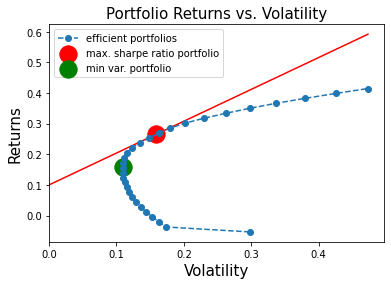

In [13]:
rets_ = rets["1996":"2000"]
num_points = 30
rf = 0.1

# supply the plot_ef function with a risk-free rate to get the tangent portfolio
plot_ef(rets_, num_points, rf, gmv=True)